## 实战案例：Elo商户类别推荐

## 一、EDA (数据探索性分析)

### 1. 分析训练集、测试集（train、test）

#### 1. 数据概览

In [818]:
# 导入库
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [819]:
# 查看竞赛提供的所有文件
os.listdir('../data/')

['Data Dictionary.xlsx',
 'Data_Dictionary.xlsx',
 'merchants.csv',
 'merchants_new.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [820]:
# 导入数据集
train = pd.read_csv('../data/train.csv')
test =  pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

# 查看数据集尺寸
print(train.shape,test.shape,submission.shape)

(201917, 6) (123623, 5) (123623, 2)


In [821]:
train

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749
...,...,...,...,...,...,...
201912,2017-09,C_ID_963962de2c,3,2,1,-2.740821
201913,2015-10,C_ID_1314773c0b,3,1,1,0.312917
201914,2017-08,C_ID_7666735b3d,4,3,0,0.093494
201915,2016-07,C_ID_73f5a0efd0,3,2,1,-4.676589


In [822]:
test

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1
...,...,...,...,...,...
123618,2017-10,C_ID_7a239d2eda,2,2,0
123619,2017-09,C_ID_75ace375ae,3,1,1
123620,2016-09,C_ID_21d56d950c,5,1,1
123621,2017-06,C_ID_6c46fc5a9d,2,1,0


In [823]:
submission

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0
...,...,...
123618,C_ID_7a239d2eda,0
123619,C_ID_75ace375ae,0
123620,C_ID_21d56d950c,0
123621,C_ID_6c46fc5a9d,0


In [824]:
# 查看训练集与测试集字段的含义
df = pd.read_excel('../data/Data_Dictionary.xlsx', sheet_name='train', skiprows=2)
for va in df.values:
    print('Column:', va[0], ' Description:', va[1])
    
# 结论：三个feature都是匿名的信用卡离散字段，还有一个首次购物的月份，而标签是在历史和评估时期后的
# 两个月进行量化计算得到的忠诚度分数(这里的evaluation period应该是指new_merchant_transactions.csv中的信息，同时
# 也是对应Data_Dictionary.xlsx里面的new_merchant_period字段)


Column: card_id  Description: Unique card identifier
Column: first_active_month  Description: 'YYYY-MM', month of first purchase
Column: feature_1  Description: Anonymized card categorical feature
Column: feature_2  Description: Anonymized card categorical feature
Column: feature_3  Description: Anonymized card categorical feature
Column: target  Description: Loyalty numerical score calculated 2 months after historical and evaluation period


In [825]:
# 校验数据准确性
assert train['card_id'].nunique() == train['card_id'].shape[0]
assert test['card_id'].nunique() == test['card_id'].shape[0]
assert test['card_id'].nunique()+ train['card_id'].nunique()  == len(set(test['card_id'].values.tolist()+ \
                                                                         train['card_id'].values.tolist()))
# 结论：训练集与测试集的card_id均为唯一值，且训练集与测试集的card_id无重复

In [826]:
# 检查缺失情况
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [827]:
# 测试集有一个缺失，目前不影响训练，可以先不做处理，看后续
test.isnull().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

#### 2. 变量分布

1. 即评价训练集与测试集的分布是否一致，分布不一致会影响测试集效果

2. 机器学习要求训练集与测试集保持独立且同分布

3. 数据集与测试集数量分布一致，但占比分布异常，说明测试集生成方式与训练集不一致，结构不同

##### 2.1 数量分布

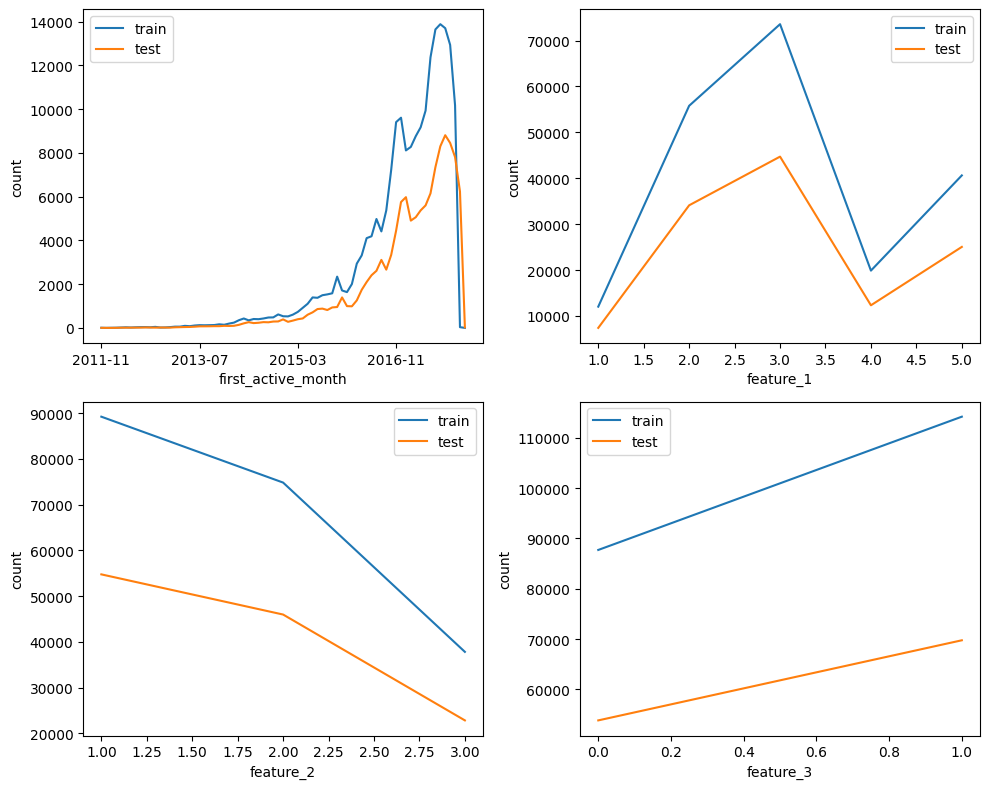

In [828]:
# 以first_active_month为例分析训练集与测试集的差异
features = ['first_active_month','feature_1','feature_2','feature_3']

# 画图显示
fig, axs = plt.subplots(math.ceil(len(features) / 2), 2 , figsize=(10, 8))
axs=axs.flatten()

# 遍历添加子图
for i,fea in enumerate(features):
    train[fea].value_counts().sort_index().plot(ax=axs[i])
    test[fea].value_counts().sort_index().plot(ax=axs[i])
    axs[i].set_xlabel(fea)
    axs[i].set_ylabel('count')
    axs[i].legend(['train', 'test'])
    plt.tight_layout()
plt.tight_layout()
plt.show()

#结论：训练集与测试集在所有单变量上的绝对数量分布形状极其相似，需要进一步查看相对占比分布

##### 2.2 占比分布
1. 占比相对于数量提供了相对分布的信息

2. 数据结构的稳定性，消除规模差异的影响，时间模式上对齐

3. 如果数量分布类似，占比分布有差异，说明数据集的样本提取有问题

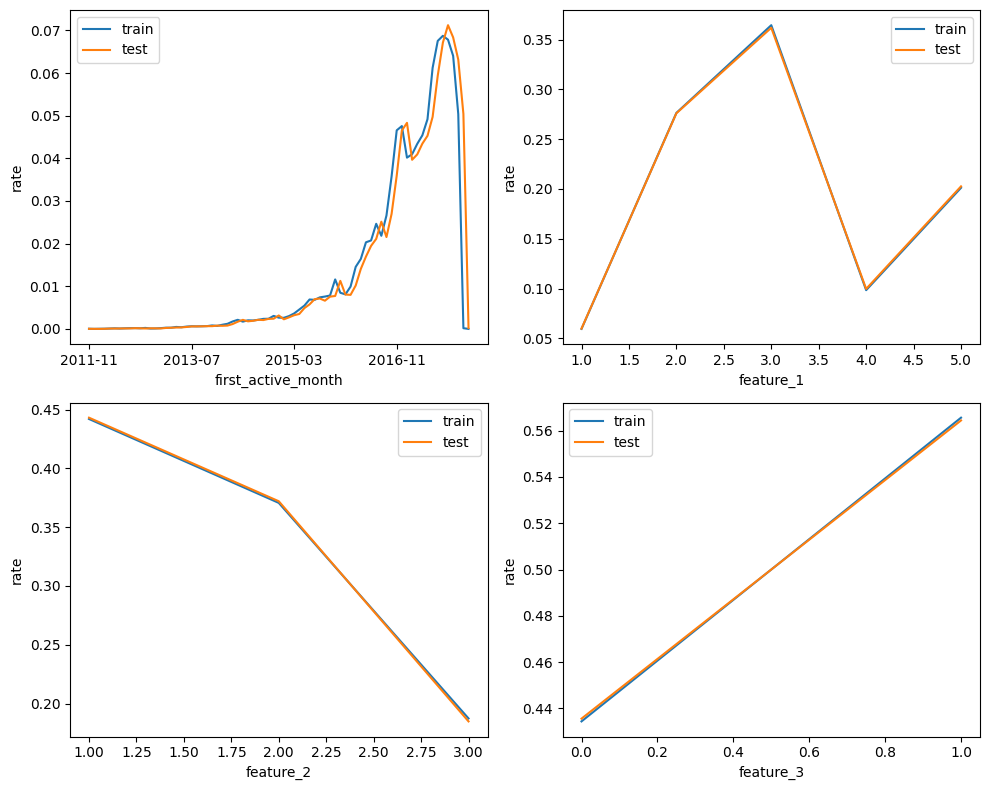

In [829]:
# 以first_active_month为例分析训练集与测试集的差异
features = ['first_active_month','feature_1','feature_2','feature_3']

# 画图显示
fig, axs = plt.subplots(math.ceil(len(features) / 2), 2 , figsize=(10, 8))
axs=axs.flatten()

# 遍历添加子图
for i,fea in enumerate(features):
    (train[fea].value_counts().sort_index()/train.shape[0]).plot(ax=axs[i])
    (test[fea].value_counts().sort_index()/test.shape[0]).plot(ax=axs[i])
    axs[i].set_xlabel(fea)
    axs[i].set_ylabel('rate')
    axs[i].legend(['train', 'test'])
    plt.tight_layout()
plt.tight_layout()
plt.show()

#结论：训练集与测试集在所有单变量上的相对占比分布形状基本一致，猜想训练集与测试集的生成方式
# 一样，继续验证联合分布以加强猜想的事实依据
#TODO：这里画图分析有一不严谨之处，即训练集与测试集的单变量取值范围可能不完全一样，由此两根线画
#在同一张图上有可能会出错，如发生偏移等，请参赛者自行验证二者的横坐标是否完全一样？如果不一样，运行
#这段代码会发生什么？在下面的联合分布验证中，我们将会填补这一遗漏之处


##### 2.3 多变量联合分布
1. 这里其实是组合特征，单变量train与test吻合，那么两个变量加在一起，看融合变量的是否也是分布一致

2. 如果两个变量融合后的分布不一致，说明样本生成的机制有问题，或者对个别变量有偏差

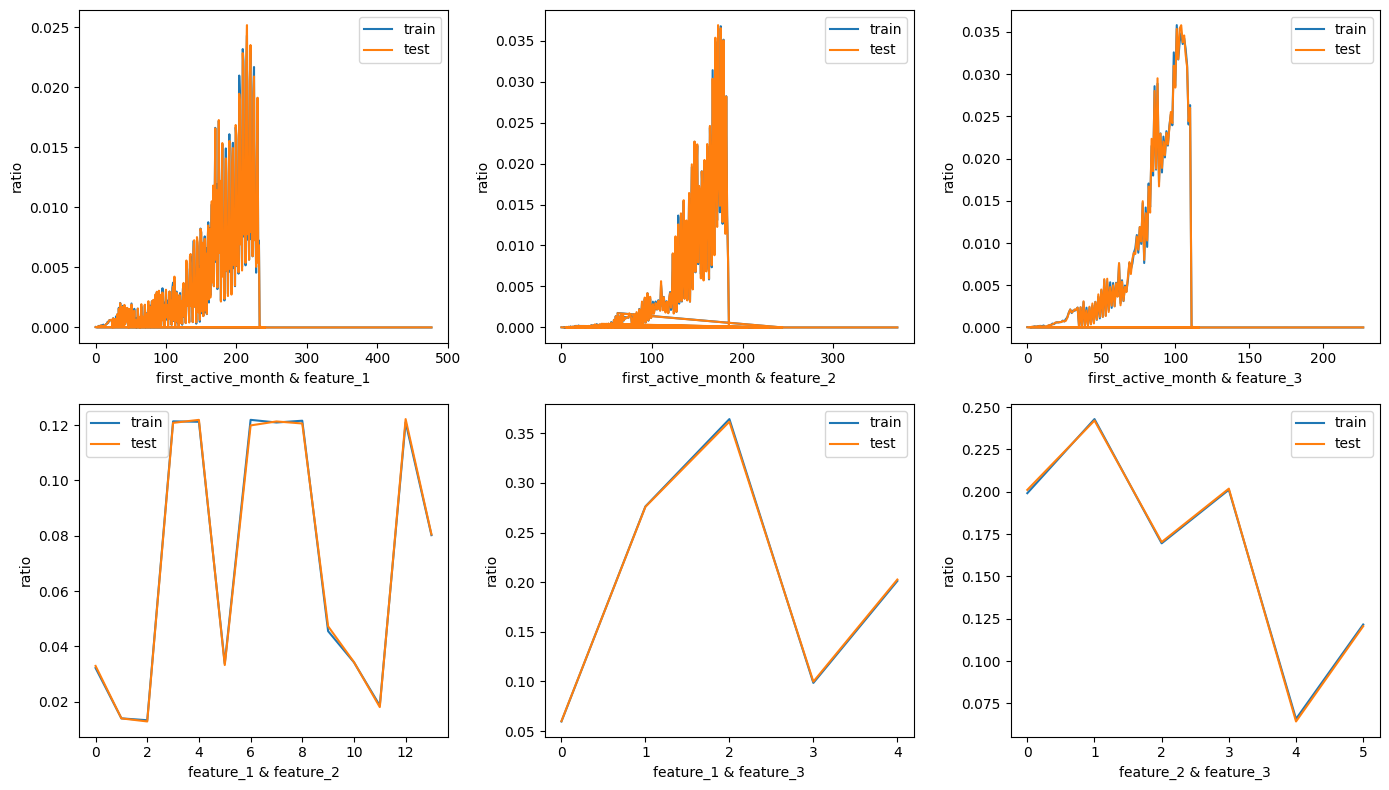

In [830]:
# 探查两两变量的联合分布

# 将两个特征str化，并用 '&' 符号加在一起，如 2017-06&5
def conbine_features(data):
    cols=data.columns
    feature1 =data[cols[0]].astype(str).values.tolist()
    feature2 =data[cols[1]].astype(str).values.tolist()
    return pd.Series([feature1[i]+'&'+feature2[i] for i in range(data.shape[0])])

n = len(features)

fig,axs = plt.subplots(2,3,figsize=(14,8 ))
axs=axs.flatten()
k=0
for i in range(n-1):
    for j in range(i+1,n):
        cols = [features[i],features[j]]
        
        # 训练集测试集 融合特征的数量占比
        train_dis = conbine_features(train[cols]).value_counts().sort_index()/train.shape[0]
        test_dis = conbine_features(test[cols]).value_counts().sort_index()/test.shape[0]

        # 融合训练集测试集的index方便画在一张图上
        index_dis = pd.Series(train_dis.index.tolist() + test_dis.index.tolist()).drop_duplicates().sort_values()

        # 将训练集、测试集的值直接映射到总的index上，对于无法覆盖到的，直接填充0
        (index_dis.map(train_dis).fillna(0)).plot(ax=axs[k])
        (index_dis.map(test_dis).fillna(0)).plot(ax=axs[k])

        # 画图
        axs[k].set_xlabel(' & '.join(cols))
        axs[k].set_ylabel('ratio')
        axs[k].legend(['train', 'test'])
        k+=1
plt.tight_layout()
plt.show()

# 结论：修正上述遗漏后参赛者可以发现训练集与测试集的两变量联合分布也基本保持一致，由此基本可以判定，训练集与测似集
# 的生成方式基本一摸一样，即测试集与训练集是同一批数据随机划分后的结果，有兴趣的参赛者可继续验证三变量和四变量分布。假定
# 关于验证集与测试集的这一猜想成立，会极大地增添参赛者后续进行特征工程的信心，对建模方式也会有一个整体把握。

#### 3. 目标概览

In [831]:
# 最后再来看看本次赛题的关键目标target,由于是忠诚度分数为连续值，通常借助pandas的describe函数进行简单统计
train['target'].describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [832]:
train["target"].value_counts()

target
-33.219281    2207
 0.000000     1630
 1.000000      117
-1.000000       81
-0.584963       35
              ... 
 0.318062        1
 0.757280        1
 0.334337        1
 1.442726        1
 0.392913        1
Name: count, Length: 197110, dtype: int64

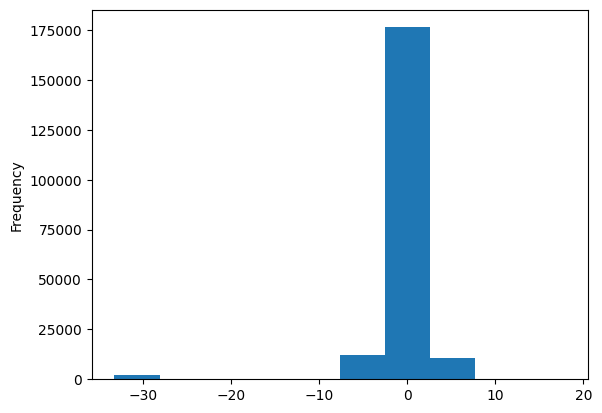

In [833]:
# 此外，关于连续值参赛者还可以借助直方图进行频域观察
train['target'].plot.hist()
plt.show()
# 结论：忠诚度分数target绝大多数集中在[-1,1]的区间

In [834]:
# 总结，查看完训练集与测试集的基本信息后，相信参赛者对赛题关键任务有了明确的
# 理解，但是对数据整体还是有一些缺失概念，因此继续探索赛题提供的其他几份数据

### 2. 分析商家基本信息 （merchant）

#### 1. 数据概览

In [835]:
# 导入数据字典，和商户信息表
df = pd.read_excel(r'../data/Data_Dictionary.xlsx', sheet_name='merchant',skiprows=2)
merchant = pd.read_csv('../data/merchants.csv')

In [836]:
# 查看数据字典中的特征名含义
for v in df.values:
    print('Column: ',v[0],'Description: ',v[1])

# 结论：可以看出商家信息表除了基本的类别数值字段，主办方还提供了商家在最近时期的各种交易量

Column:  merchant_id Description:  Unique merchant identifier
Column:  merchant_group_id Description:  Merchant group (anonymized )
Column:  merchant_category_id Description:  Unique identifier for merchant category (anonymized )
Column:  subsector_id Description:  Merchant category group (anonymized )
Column:  numerical_1 Description:  anonymized measure
Column:  numerical_2 Description:  anonymized measure
Column:  category_1 Description:  anonymized category
Column:  most_recent_sales_range Description:  Range of revenue (monetary units) in last active month --> A > B > C > D > E
Column:  most_recent_purchases_range Description:  Range of quantity of transactions in last active month --> A > B > C > D > E
Column:  avg_sales_lag3 Description:  Monthly average of revenue in last 3 months divided by revenue in last active month
Column:  avg_purchases_lag3 Description:  Monthly average of transactions in last 3 months divided by transactions in last active month
Column:  active_months_l

#### 2. 数据准确性验证

In [837]:
# 首先检查商家信息数据的正确性
print(merchant.shape, merchant['merchant_id'].nunique())
print(pd.Series(merchant.columns.tolist()).sort_values().values ==  pd.Series([va[0] for va in df.values]).sort_values().values)

# 结论: 特征信息完全对上，且商家信息记录数据表不唯一，后续处理需要注意
merchant.head()

(334696, 22) 334633
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


#### 3. 离散、连续数据探查和处理

In [838]:
# 根据商家信息表字段的离散和连续属性，参赛者可将两类字段分开后统一化分析，现字段分离如下
category_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'category_4', 'city_id', 'state_id', 'category_2']
numeric_cols = ['numerical_1', 'numerical_2',
     'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']
assert len(category_cols) + len(numeric_cols) == merchant.shape[1]

##### 3.1 离散数据object类型处理

In [839]:
merchant[category_cols].dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [840]:
merchant[category_cols].nunique()

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

In [841]:
# 对object类型进行处理，处理成数字
# 统计里面的离散值的个数，按照个数，生成一个从0-n的list, 一一map上
def change_object_cols(se): 
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value)), index=value)).values
for col in ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']:
    merchant[col] = change_object_cols(merchant[col])

merchant[category_cols].dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
category_1                       int64
most_recent_sales_range          int64
most_recent_purchases_range      int64
category_4                       int64
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

##### 3.2 离散缺失值处理

In [842]:
# 看下缺失值
merchant.isnull().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [843]:
# 对缺失值以-1填充
merchant['category_2'] = merchant['category_2'].fillna(-1)

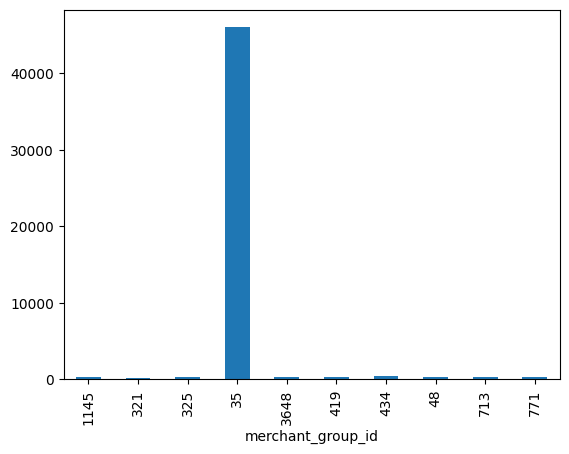

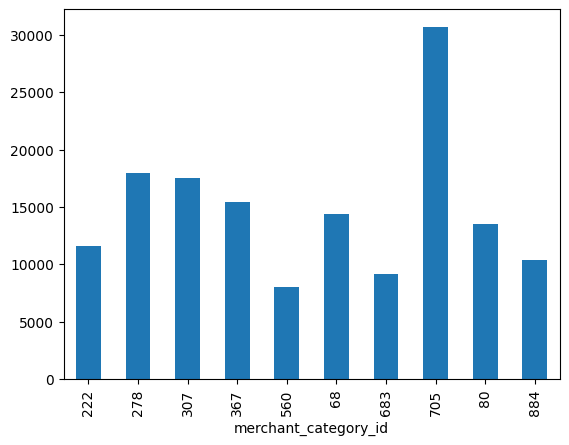

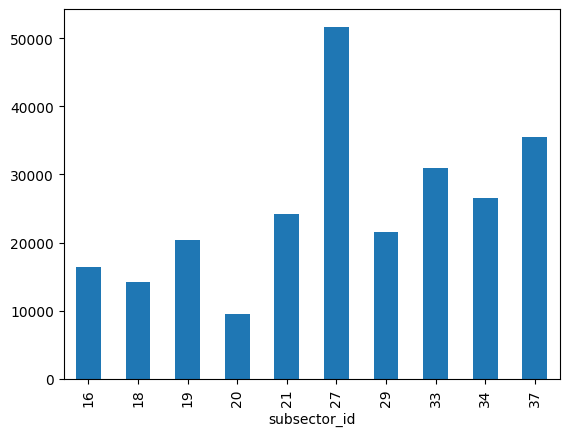

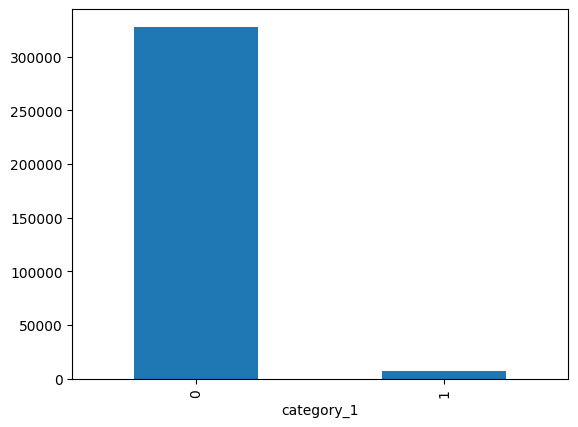

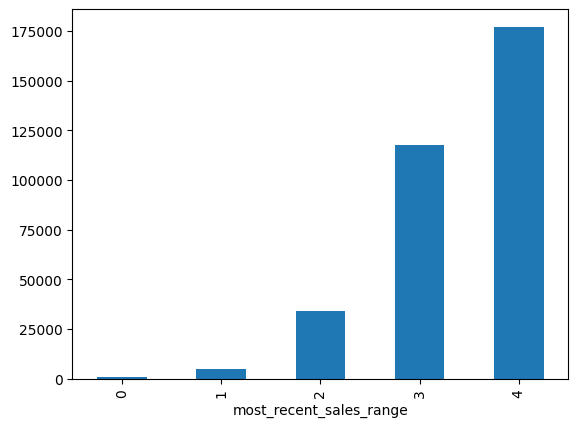

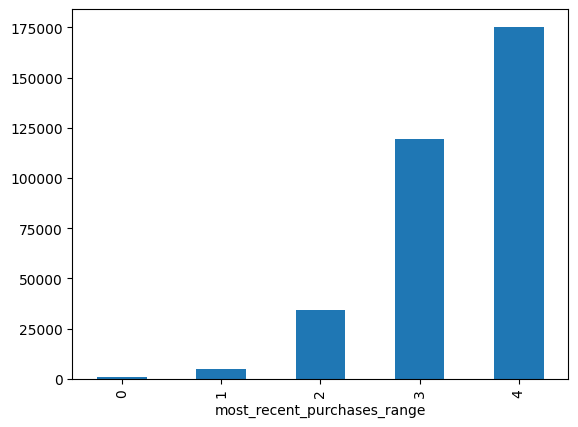

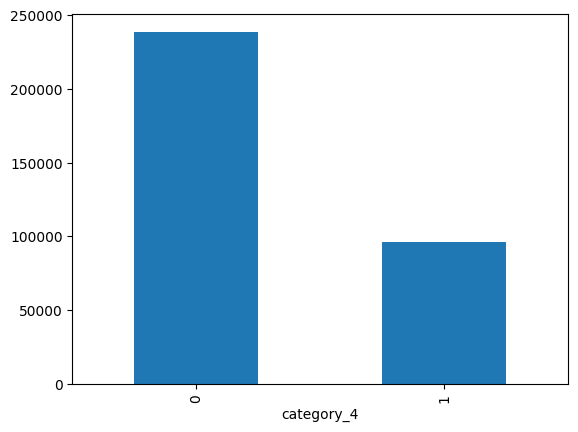

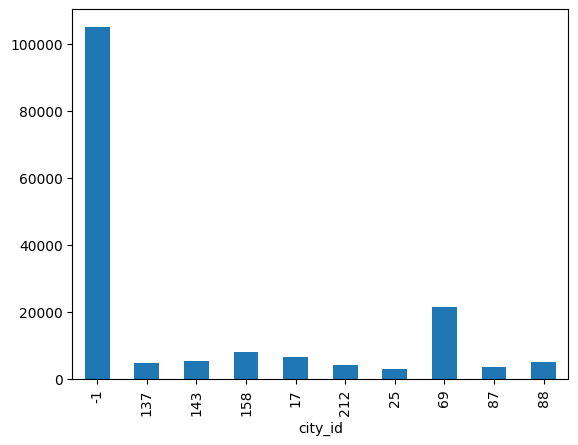

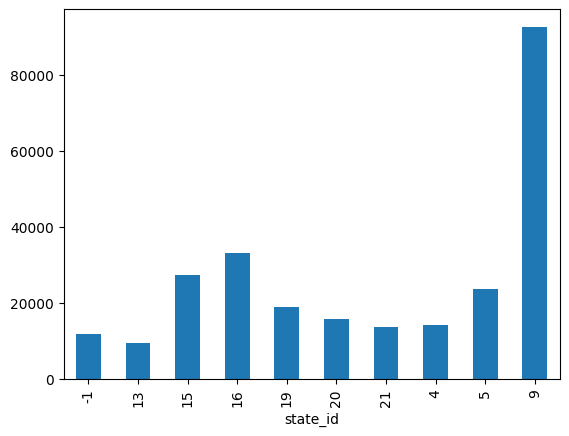

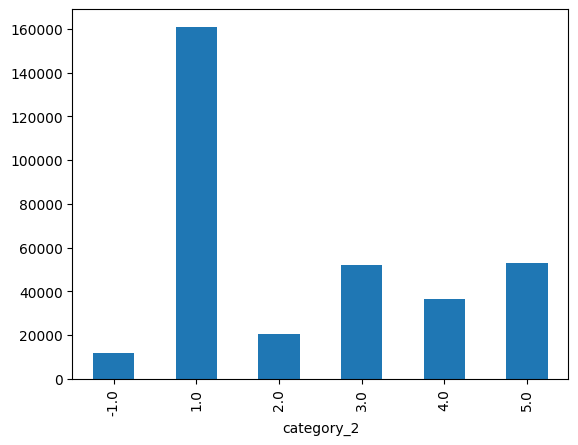

In [844]:
# 简单看下每个离散字段Top10的数量分布
for col in category_cols[1:]:
    merchant[col].astype(str).value_counts()[:10].sort_index().plot.bar()
    plt.show()
    
# 结论：在建模思路还不明确的情况下，参赛者可适当进行数据探查，也不必盲目面面俱到，做到心中有数
# 对数据结构有个清晰的了解，以便后续快速进行构思与方案验证

##### 3.3 连续数据的正无穷，缺失值处理

In [845]:
# 对连续型字段探查
merchant[numeric_cols].describe()

# 发现有正无穷值，这也是模型所不能接受的，因此需要对无限值进行处理

d:\ProgramData\miniconda3\envs\ml\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
d:\ProgramData\miniconda3\envs\ml\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
d:\ProgramData\miniconda3\envs\ml\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334696.000000,334696.000000,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000
mean,0.011476,0.008103,13.832993,inf,2.994108,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335
std,1.098154,1.070497,2395.489999,NaN,0.095247,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138
min,-0.057471,-0.057471,-82.130000,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000
25%,-0.057471,-0.057471,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000
50%,-0.057471,-0.057471,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000
75%,-0.047556,-0.047556,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000
max,183.735111,182.079322,851844.640000,inf,3.000000,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000


In [846]:
# 先给inf替换成-99，之后查看当前数据集的最大值，以最大值再替换inf，想法很特别
inf_cols = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']
merchant[inf_cols] = merchant[inf_cols].replace(np.inf, merchant[inf_cols].replace(np.inf, -99).max().max())
merchant[numeric_cols].describe()

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334696.000000,334696.000000,334683.000000,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000
mean,0.011476,0.008103,13.832993,2.145143,2.994108,2.165079e+01,2.441947,5.947397,2.522771e+01,2.633572,11.599335
std,1.098154,1.070497,2395.489999,213.955844,0.095247,3.947108e+03,209.439373,0.394936,5.251842e+03,205.206198,1.520138
min,-0.057471,-0.057471,-82.130000,0.333495,1.000000,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000
25%,-0.057471,-0.057471,0.880000,0.923650,3.000000,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000
50%,-0.057471,-0.057471,1.000000,1.016667,3.000000,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000
75%,-0.047556,-0.047556,1.160000,1.146522,3.000000,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000
max,183.735111,182.079322,851844.640000,61851.333333,3.000000,1.513959e+06,61851.333333,6.000000,2.567408e+06,61851.333333,12.000000


In [847]:
# 对于离散字段的缺失值处理方式也有多样，这里先使用平均值进行填充，后续有需要再进行优化处理
for col in numeric_cols:
    merchant[col] = merchant[col].fillna(merchant[col].mean())

merchant[numeric_cols].describe()

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,3.346960e+05,334696.000000,334696.000000,3.346960e+05,334696.000000,334696.000000
mean,0.011476,0.008103,13.832993,2.145143,2.994108,2.165079e+01,2.441947,5.947397,2.522771e+01,2.633572,11.599335
std,1.098154,1.070497,2395.443476,213.955844,0.095247,3.947031e+03,209.439373,0.394936,5.251740e+03,205.206198,1.520138
min,-0.057471,-0.057471,-82.130000,0.333495,1.000000,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000
25%,-0.057471,-0.057471,0.880000,0.923650,3.000000,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000
50%,-0.057471,-0.057471,1.000000,1.016667,3.000000,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000
75%,-0.047556,-0.047556,1.160000,1.146522,3.000000,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000
max,183.735111,182.079322,851844.640000,61851.333333,3.000000,1.513959e+06,61851.333333,6.000000,2.567408e+06,61851.333333,12.000000


### 3. 分析信用卡用户交易记录 （new_merchant_transactions.csv、historical_transactions.csv）

#### 1. 数据概览

In [848]:
# 导入数据
new_transaction = pd.read_csv(r'D:\Program Projects\Python Projects\temp\elo-merchant-category-recommendation\new_merchant_transactions.csv')
history_transaction = pd.read_csv(r'D:\Program Projects\Python Projects\temp\elo-merchant-category-recommendation\historical_transactions.csv', nrows=10000)

df_history = pd.read_excel('../data/Data_Dictionary.xlsx', sheet_name='history', skiprows=2)
df_new = pd.read_excel('../data/Data_Dictionary.xlsx', sheet_name='new_merchant_period', skiprows=2)

In [849]:
new_transaction['installments'].describe()

count    1.963031e+06
mean     6.829643e-01
std      1.584069e+00
min     -1.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.990000e+02
Name: installments, dtype: float64

In [850]:
history_transaction.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [851]:
# 查看历史表字段含义

print(df_history.shape)
for va in df_history.values:
    print('Column:', va[0], ' Description:', va[1])
    
# 查看新交易表字段含义
print(df_new.shape)
for va in df_new.values:
    print('Column:', va[0], ' Description:', va[1])


# 结论：可以看出两张交易记录信息表字段一致，且除了数量与金额之外均为类别字段
# 可按照与商家信息表类似的方式对交易记录表进行简单分析，但由于交易记录表的id索引并不唯一
# 所有的类别字段都值得进行探索分析，当然也可以顺带进行数据的处理
# 特别注意：有时离散字段与连续字段之间的分界并不明显，有的字段既可以作为离散字段处理，又可以
# 作为连续字段进行处理，此外，这里出现了很特别的一个字段就是时间，这里我们会专门讲解时间字段的处理

(14, 2)
Column: card_id  Description: Card identifier
Column: month_lag  Description: month lag to reference date
Column: purchase_date  Description: Purchase date
Column: authorized_flag  Description: Y' if approved, 'N' if denied
Column: category_3  Description: anonymized category
Column: installments  Description: number of installments of purchase
Column: category_1  Description: anonymized category
Column: merchant_category_id  Description: Merchant category identifier (anonymized )
Column: subsector_id  Description: Merchant category group identifier (anonymized )
Column: merchant_id  Description: Merchant identifier (anonymized)
Column: purchase_amount  Description: Normalized purchase amount
Column: city_id  Description: City identifier (anonymized )
Column: state_id  Description: State identifier (anonymized )
Column: category_2  Description: anonymized category
(14, 2)
Column: card_id  Description: Card identifier
Column: month_lag  Description: month lag to reference date
C

#### 2. 离散、连续数据处理

In [852]:
# 校验columns

# 连续数据
numeric_cols = [ 'installments', 'month_lag', 'purchase_amount']

# 离散数据
category_cols = ['authorized_flag', 'card_id', 'city_id', 'category_1',
       'category_3', 'merchant_category_id', 'merchant_id', 'category_2', 'state_id',
       'subsector_id']
time_cols = ['purchase_date']
assert len(numeric_cols) + len(category_cols) + len(time_cols) == new_transaction.shape[1]

In [853]:
# 对比商家信息表和交易表，找出共有的字段，说不定可供表联合，可以发现与商家信息id有重复字段，因此确认二者含义是否一致
duplicate_cols = []
for col in merchant.columns:
    if col in new_transaction.columns:
        duplicate_cols.append(col)
print(duplicate_cols)

['merchant_id', 'merchant_category_id', 'subsector_id', 'category_1', 'city_id', 'state_id', 'category_2']


In [854]:
print(new_transaction[duplicate_cols].drop_duplicates().shape)
print(new_transaction.shape)
print(new_transaction['merchant_id'].nunique())
print(merchant['merchant_id'].nunique(), merchant.shape)
# 结论：由此可以看出交易记录表中的merhcant_id相关信息并不唯一，有可能会发生动态变化如评分等级等等
# 因此优先建议使用商户表中的相应记录
merchant[duplicate_cols].head()

(291242, 7)
(1963031, 14)
226129
334633 (334696, 22)


,merchant_id,merchant_category_id,subsector_id,category_1,city_id,state_id,category_2
0,M_ID_838061e48c,792,9,0,242,9,1.0
1,M_ID_9339d880ad,840,20,0,22,16,1.0
2,M_ID_e726bbae1e,690,1,0,-1,5,5.0
3,M_ID_a70e9c5f81,792,9,1,-1,-1,-1.0
4,M_ID_64456c37ce,222,21,1,-1,-1,-1.0


In [855]:
new_transaction[duplicate_cols].head()

,merchant_id,merchant_category_id,subsector_id,category_1,city_id,state_id,category_2
0,M_ID_b0c793002c,307,19,N,107,9,1.0
1,M_ID_88920c89e8,307,19,N,140,9,1.0
2,M_ID_ad5237ef6b,507,14,N,330,9,1.0
3,M_ID_9e84cda3b1,661,8,Y,-1,-1,NaN
4,M_ID_3c86fa3831,166,29,Y,-1,-1,NaN


In [856]:
new_transaction[category_cols].head()

,authorized_flag,card_id,city_id,category_1,category_3,merchant_category_id,merchant_id,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,B,307,M_ID_b0c793002c,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,B,307,M_ID_88920c89e8,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,B,507,M_ID_ad5237ef6b,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,B,661,M_ID_9e84cda3b1,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,B,166,M_ID_3c86fa3831,NaN,-1,29


In [857]:
# 可仿照merchant的处理方式对字符型的离散特征进行编码（id除外）
for col in ['authorized_flag', 'category_1', 'category_3']:
    new_transaction[col] = change_object_cols(new_transaction[col].fillna(-1).astype(str))
new_transaction[category_cols] = new_transaction[category_cols].fillna(-1)
new_transaction[category_cols].head()

,authorized_flag,card_id,city_id,category_1,category_3,merchant_category_id,merchant_id,category_2,state_id,subsector_id
0,0,C_ID_415bb3a509,107,0,2,307,M_ID_b0c793002c,1.0,9,19
1,0,C_ID_415bb3a509,140,0,2,307,M_ID_88920c89e8,1.0,9,19
2,0,C_ID_415bb3a509,330,0,2,507,M_ID_ad5237ef6b,1.0,9,14
3,0,C_ID_415bb3a509,-1,1,2,661,M_ID_9e84cda3b1,-1.0,-1,8
4,0,C_ID_ef55cf8d4b,-1,1,2,166,M_ID_3c86fa3831,-1.0,-1,29


In [858]:
category_cols

['authorized_flag',
 'card_id',
 'city_id',
 'category_1',
 'category_3',
 'merchant_category_id',
 'merchant_id',
 'category_2',
 'state_id',
 'subsector_id']

In [859]:
# 由于两张交易表是根据信用卡用户消费的时间来进行区分，因此有必要着重分析这二者之间的区别与联系
print(new_transaction['month_lag'].describe())
print('\n')
print(new_transaction['purchase_date'].min(), 'to', new_transaction['purchase_date'].max())

count    1.963031e+06
mean     1.476515e+00
std      4.994483e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: month_lag, dtype: float64


2017-03-01 03:24:51 to 2018-04-30 23:59:59


In [860]:
print(history_transaction['month_lag'].describe())
print('\n')
print(history_transaction['purchase_date'].min(), 'to', history_transaction['purchase_date'].max())

count    10000.000000
mean        -5.507300
std          3.644431
min        -13.000000
25%         -8.000000
50%         -5.000000
75%         -2.000000
max          0.000000
Name: month_lag, dtype: float64


2017-01-01 10:26:05 to 2018-02-28 19:14:02


In [861]:
# 看到这里参赛者难免会有些疑惑，所谓历史与最新的交易整体时间窗差距两个月，但并不是代表
# 每个用户的交易记录时间均处在同一时间窗，因此有必要重新审视一下用户的注册日期
print(train['first_active_month'].min(), train['first_active_month'].max())
print(test['first_active_month'].dropna().min(), test['first_active_month'].dropna().max())

2011-11 2018-02
2011-11 2018-01


In [862]:
#分析每个用户在存在交易月份数量上的差异
history_transaction.groupby('card_id')['month_lag'].nunique().describe()

count    37.000000
mean     10.864865
std       3.198630
min       5.000000
25%       8.000000
50%      11.000000
75%      14.000000
max      14.000000
Name: month_lag, dtype: float64

In [863]:
# 关于时间的处理上，可以按照一些字符串操作提取相应的信息，比如直接提取年份、月份、日期和小时点等等
# 还有一种相对万能可适用于各种场景的办法就是使用unix时间戳，可以灵活用于各种转换与计算
new_transaction[new_transaction['month_lag']==1]['purchase_date'].apply(lambda x:'-'.join(x.split(' ')[0].split('-')[:2])).value_counts()

purchase_date
2018-03    734538
2018-02     67974
2018-01     52501
2017-12     41424
2017-11     24105
2017-10     21455
2017-09     18089
2017-07     16093
2017-08     15959
2017-06     12089
2017-05     11750
2017-04     10342
2017-03      1298
Name: count, dtype: int64

In [864]:
history_transaction[history_transaction['month_lag']==0]['purchase_date'].apply(lambda x:'-'.join(x.split(' ')[0].split('-')[:2])).value_counts()

purchase_date
2018-02    628
2017-08     35
2018-01     10
2017-09      9
2017-11      7
2017-12      6
Name: count, dtype: int64

In [865]:
#结论：由上面可知month_lag是一个相对值，每个信用卡id的month_lag=0的月份都不一样，即用户最新一次购物的时间不一样
#显然越是出现在最新日期的用户越有可能粘性越强价值越高，也就是题目所衡量的越忠诚

### 4. 目标列相关指标分析

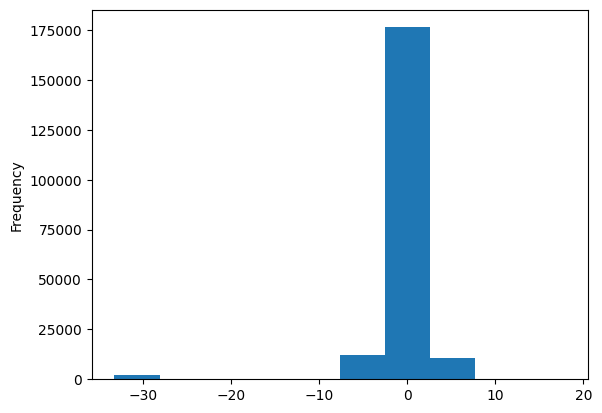

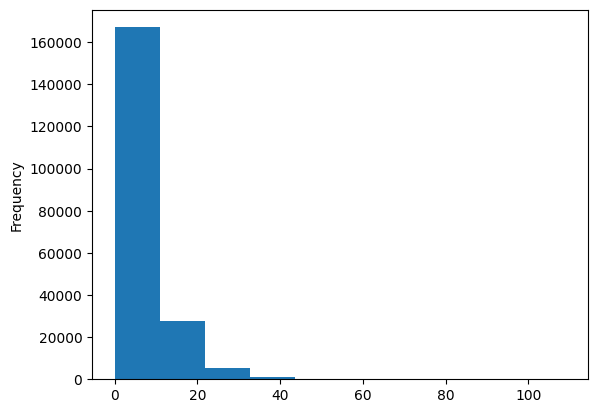

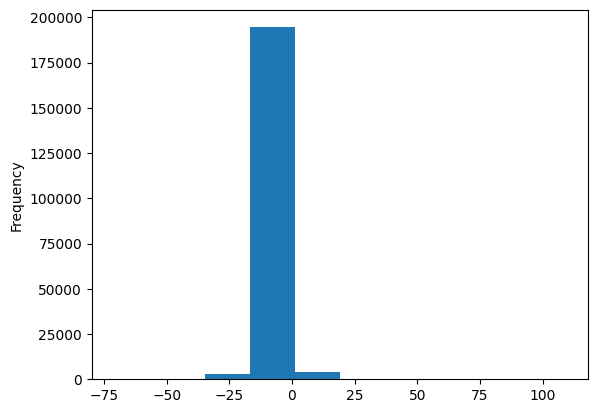

In [866]:
# 在熟悉基本比赛数据后，直觉上参赛者可考虑使用RFM分析，即采用recent、frequency、money进行
# 目标列相关性分析,简单起见，这里以new_transaction为例，由于都是最近记录因此就不统计recent
card_rfm = train[['card_id', 'target']].copy()

card_rfm['frequency'] = card_rfm['card_id'].map(new_transaction['card_id'].value_counts()).fillna(0).values
card_rfm['money'] = card_rfm['card_id'].map(new_transaction.groupby('card_id')['purchase_amount'].sum()).fillna(0).values

card_rfm = card_rfm.sort_values('target').reset_index(drop=True)
for col in ['target', 'frequency', 'money']:
    card_rfm[col].plot.hist()
    plt.show()
    
# 结论：可以看出，target高的用户集中在频次与消费都高的区域，这个发现也比较符合逻辑

### 5. 基本建模思路

In [867]:
# 总结：通过基本的数据探索性分析，相信参赛者对数据以及对赛题任务都有了一个良好的理解，相信
# 本赛题的重点便是挖掘用户的各种交易行为与目标列的关系，进而达到良好的模型学习效果，准确预测
# 测试集用户的忠诚度分数。因此这是一个关注信用卡用户局部消费偏好画像的题目，通过找到相似的训练集用户来
# 类推测试集用户的忠诚度分数，进而对高价值人群进行区分，给商家与信用卡银行提供决策支持，同时也
# 提升消费者体验，由此特征工程可集中于用户的交易行为画像